In [1]:
import sys
quic_path = '/home/quic/QUIC-Projects'
if not quic_path in sys.path:
    sys.path.append(quic_path)

In [2]:
import numpy as np 
from matplotlib import pyplot as plt

In [3]:

# for SVM
from classifiers.convex.svm import BinarySVM
from classifiers.kernel import Kernel
from classifiers.datasets.dataloader import Example_4x2
# for QASVM
from classifiers.quantum import Qasvm_Mapping_4x2
from classifiers.quantum.qasvm import QASVM
from classifiers.quantum.quantum_circuits import AnsatzCircuit9
from classifiers.optimizer import SPSA
from qiskit.utils import QuantumInstance
from qiskit.ignis.mitigation import CompleteMeasFitter
from qiskit.circuit.library import RealAmplitudes, EfficientSU2, NLocal, TwoLocal
from qiskit.providers.aer import AerSimulator
from qiskit import IBMQ
# for logging & visualization
import logging
from classifiers.callback import CostParamStorage, ParamsStopping
from torch.utils.tensorboard import SummaryWriter
from classifiers.visualization import Plot_Data, Plot_Log_From_SPSA, Plot_SVM, compare_svm_and_qasvm

if IBMQ.active_account() is None:
    IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-kaist', group='internal', project='default')
backend = provider.get_backend('ibmq_montreal')
backend

layout = Qasvm_Mapping_4x2(backend, line_mapping=[1, 2, 3, 5, 8, 11, 14, 13, 12])
layout

Layout({
8: Qubit(QuantumRegister(1, 'a'), 0),
5: Qubit(QuantumRegister(2, 'i'), 0),
3: Qubit(QuantumRegister(2, 'i'), 1),
2: Qubit(QuantumRegister(1, 'xi'), 0),
1: Qubit(QuantumRegister(1, 'yi'), 0),
11: Qubit(QuantumRegister(2, 'j'), 0),
14: Qubit(QuantumRegister(2, 'j'), 1),
13: Qubit(QuantumRegister(1, 'xj'), 0),
12: Qubit(QuantumRegister(1, 'yj'), 0)
})

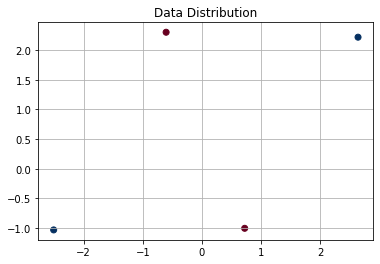

In [4]:
X, y = Example_4x2(True)()
Plot_Data(X, y).plot()

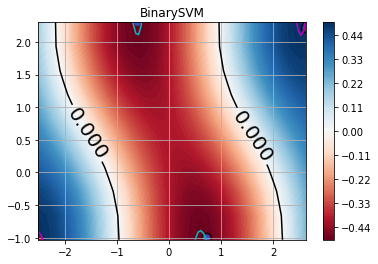

In [5]:
svm = BinarySVM(Kernel('SingleQubit', reps=1), mutation='REDUCED_QASVM', C=None, k=10)
svm.fit(X, y)
Plot_SVM(svm).plot_boundary()

60
64


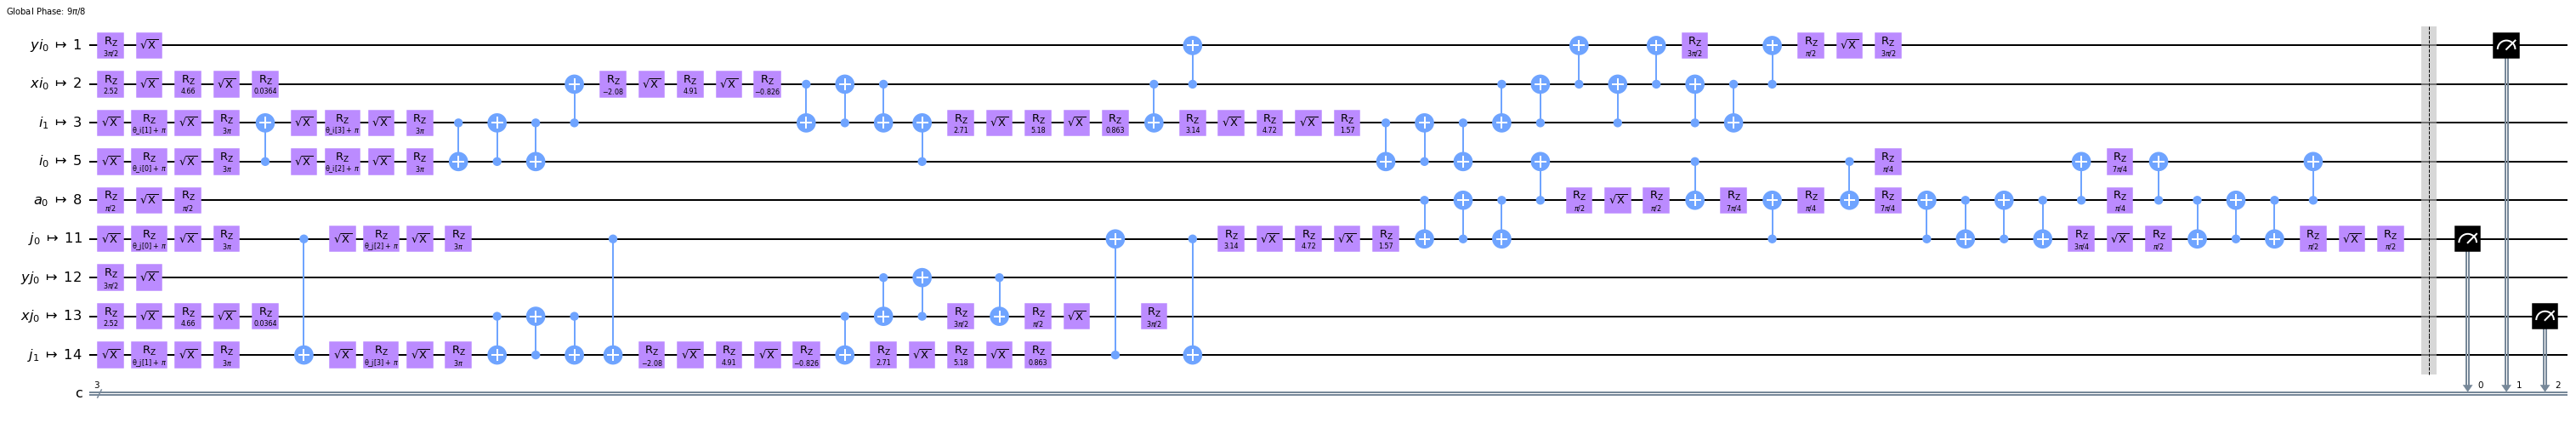

In [6]:
var_form = RealAmplitudes(2, reps=1)
#var_form = AnsatzCircuit9(2, reps=5, rotational_block='rx', entangling_block='cz')
#var_form = TwoLocal(2, reps=5, rotation_blocks='rz', entanglement_blocks='cx', entanglement='linear')
#var_form = EfficientSU2(2, reps=1)
quantum_instance = QuantumInstance(AerSimulator.from_backend(backend), shots=2**13, seed_transpiler=100, optimization_level=2, initial_layout=layout, measurement_error_mitigation_cls=CompleteMeasFitter)
#quantum_instance = QuantumInstance(AerSimulator(), shots=2**13)
qasvm = QASVM(X, y, quantum_instance=quantum_instance, C=None, k=10, option='Bloch_sphere', var_form=var_form).dual
print(qasvm.second_order_circuit.depth())
print(qasvm.first_order_circuit.depth())
qasvm.second_order_circuit.draw(fold=-1, output='mpl', idle_wires=False)

In [7]:
from tqdm.notebook import tqdm
def find_min_seed(quantum_instance):
    old_tv = 1000
    for i in tqdm(range(100)):
        old_seed = quantum_instance.compile_config['seed_transpiler']
        quantum_instance.compile_config['seed_transpiler'] = i
        qasvm = QASVM(X, y, quantum_instance=quantum_instance, C=None, k=10, option='Bloch_sphere', var_form=var_form).dual
        new_tv = qasvm.second_order_circuit.depth() + qasvm.first_order_circuit.depth() + np.abs(qasvm.second_order_circuit.depth() - qasvm.first_order_circuit.depth())**2
        if new_tv < old_tv:
            old_tv = new_tv
        else:
            quantum_instance.compile_config['seed_transpiler'] = old_seed
    return quantum_instance.compile_config['seed_transpiler']

In [8]:
seed=find_min_seed(quantum_instance)
print(seed)

  0%|          | 0/100 [00:00<?, ?it/s]

20


59
59


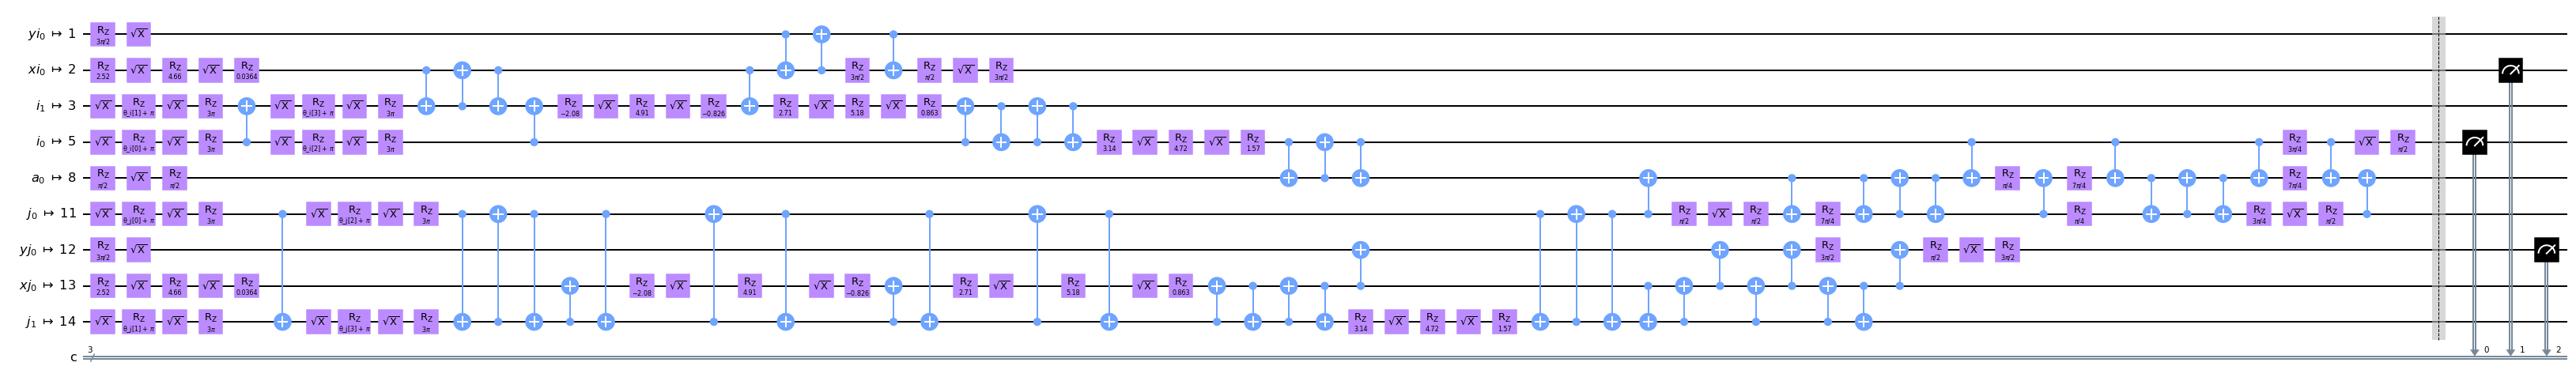

In [9]:
quantum_instance = QuantumInstance(AerSimulator.from_backend(backend), shots=2**13, seed_transpiler=seed, optimization_level=2, initial_layout=layout, measurement_error_mitigation_cls=CompleteMeasFitter)
#quantum_instance = QuantumInstance(AerSimulator(), shots=2**13)
qasvm = QASVM(X, y, quantum_instance=quantum_instance, C=None, k=10, option='Bloch_sphere', var_form=var_form).dual
print(qasvm.second_order_circuit.depth())
print(qasvm.first_order_circuit.depth())
qasvm.second_order_circuit.draw(fold=-1, output='mpl', idle_wires=False)

In [10]:
from tqdm.notebook import tqdm

epochs = 2**10
last_avg = 2**4
optimizer = SPSA(qasvm, blocking=True)
storage = CostParamStorage(interval=1)

for epoch in tqdm(range(epochs), desc='SPSA opt'):
    optimizer.step(storage)
    if storage.num_accepted()>=last_avg and storage.last_cost_std(last_avg, ignore_rejected=True)<=optimizer.allowed_increase/2:
        break

qasvm.parameters = storage.last_avg(last_avg, ignore_rejected=True)


SPSA opt:   0%|          | 0/1024 [00:00<?, ?it/s]

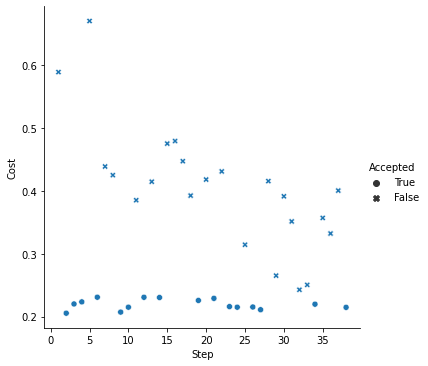

In [11]:
storage.plot()

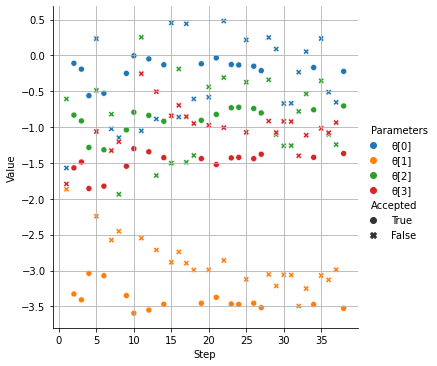

In [12]:
storage.plot_params()

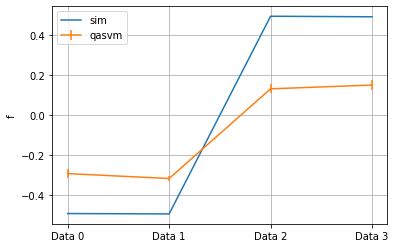

In [13]:
regression = compare_svm_and_qasvm(svm, qasvm)

59
59


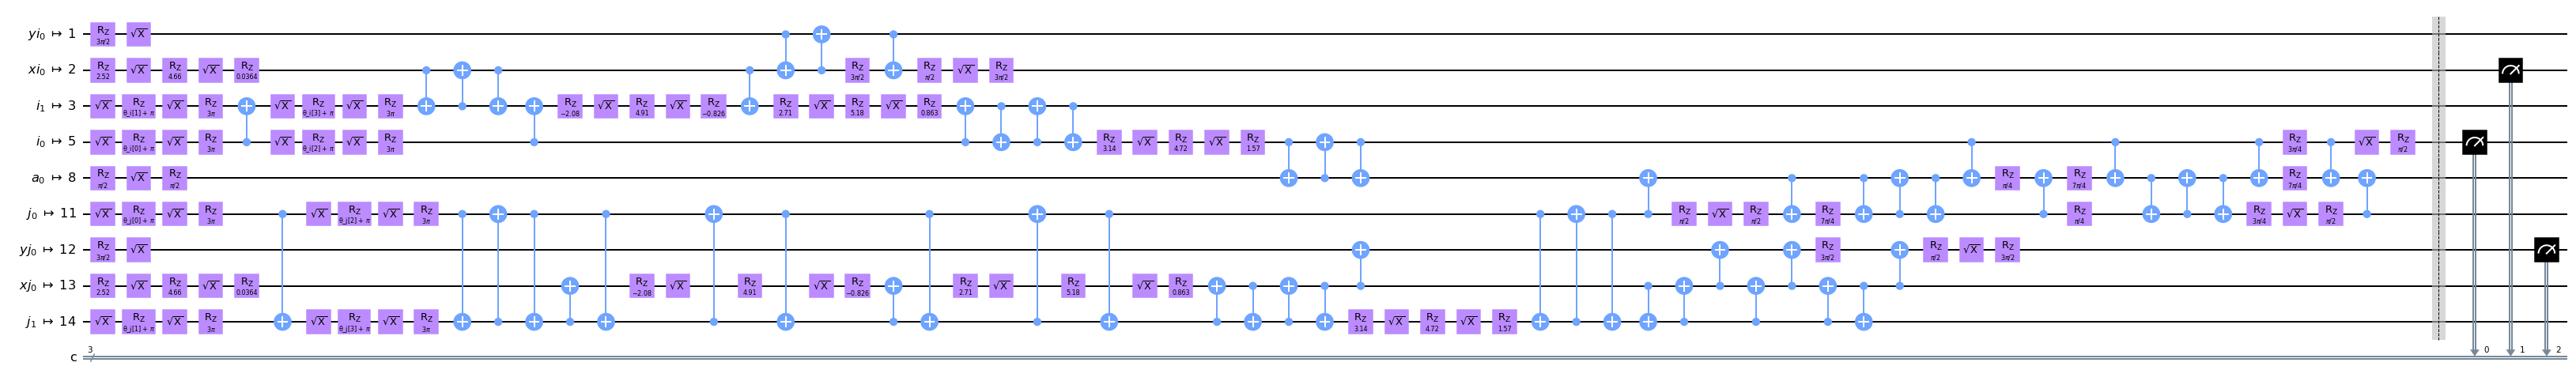

In [14]:
real_quantum_instance = QuantumInstance(backend=backend, shots=2**13, seed_transpiler=seed, optimization_level=2, initial_layout=layout, measurement_error_mitigation_cls=CompleteMeasFitter)
real_qasvm = QASVM(X, y, quantum_instance=real_quantum_instance, C=None, k=10, option='Bloch_sphere', var_form=var_form).dual
print(real_qasvm.second_order_circuit.depth())
print(real_qasvm.first_order_circuit.depth())
real_qasvm.second_order_circuit.draw(fold=-1, output='mpl', idle_wires=False)

In [15]:
real_qasvm.parameters = storage.last_avg(last_avg)
epochs = 2**10
last_avg = 2**4
real_optimizer = SPSA(qasvm, blocking=True)
real_optimizer.model = real_qasvm
real_storage = CostParamStorage(interval=1)

for epoch in tqdm(range(epochs), desc='SPSA opt'):
    real_optimizer.step(real_storage)
    if real_storage.num_accepted()>=last_avg and real_storage.last_cost_std(last_avg, ignore_rejected=True)<=real_optimizer.allowed_increase/2:
        break

real_qasvm.parameters = real_storage.last_avg(last_avg, ignore_rejected=True)

SPSA opt:   0%|          | 0/1024 [00:00<?, ?it/s]

/home/quic/anaconda3/envs/QUIC/lib/python3.9/site-packages/qiskit/utils/run_circuits.py:382: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj, **backend_options, **noise_config)


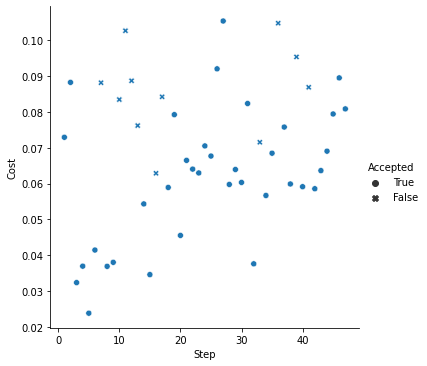

In [16]:
real_storage.plot()

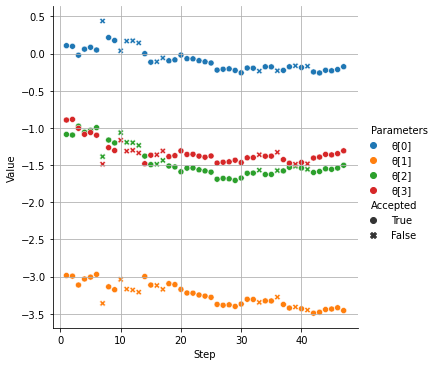

In [17]:
real_storage.plot_params()

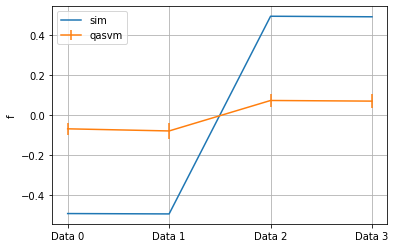

In [18]:
real_regression = compare_svm_and_qasvm(svm, real_qasvm)

In [20]:
real_storage.save('./montreal/real_storage')
real_qasvm.save('./montreal/real_qasvm')
np.save('./montreal/real_regression', real_regression)

In [21]:
storage.save('./montreal/sim_storage')
qasvm.save('./montreal/sim_qasvm')
np.save('./montreal/sim_regression', regression)

In [22]:
real_qasvm.parameters = storage.last_avg(last_avg, ignore_rejected=True)

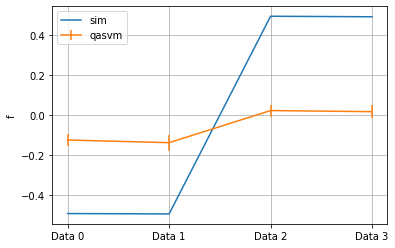

In [23]:
fake_regression = compare_svm_and_qasvm(svm, real_qasvm)